<a href="https://colab.research.google.com/github/chldydgh4687/Kaggle/blob/master/Titanic(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !ls -lha kaggle.json

!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6


# 캐글연동을 위한 토큰 입력
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


# 버전이 1.5.6 이 아니면, 진행할 수 없다
! kaggle -v 

-rw-r--r-- 1 root root 66 Dec 25 13:46 kaggle.json
Uninstalling kaggle-1.5.6:
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.3.1)
     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=703f410ad9c4fd426c26403f23ed0bc129353d969ef5c06dd140c7774f24caab
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
Kaggle API 1.5.6


In [2]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 24.6MB/s]


In [44]:
import zipfile
import os

os.mkdir('/content/input')

zip_ref = zipfile.ZipFile("/content/titanic.zip", 'r')
zip_ref.extractall("/content/input")
zip_ref.close()

FileExistsError: ignored

소개

이 노트북은 stacking이라 알려진 머신러닝 앙상블 모델의 기초적인 소개이다. nutshell stacking. 

In [45]:
#Load in our Libraries

import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

#sklearn 0.22
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

Feature Exploration, Engineering and Cleaning (데이터 정제)
- 

In [46]:
#Load in the train and test datasets
train = pd.read_csv('/content/input/train.csv')
test = pd.read_csv('/content/input/test.csv')

#Store our passenger ID for easy access

passengerid = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [0]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)

# 카빈을 가졌는지 안가졌는지 표시
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

In [0]:
# 위 sina 로 부터 data step을 가져옴
# SibSp and Parch 의 병합인 새로운 familysize를 생성한다.

for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# loc?

# null값 삭제

for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

#fillna?
#qcut?

for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'],4)

for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size = age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

In [0]:
def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  
  if title_search:
    return title_search.group(1)
  return ""

for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr',
                                               'Major','Rev','Sir','Jonkheer','Dona'],'Rare')
  dataset['Title'] = dataset['Title'].replace('Mile','Miss')
  dataset['Title'] = dataset['Title'].replace('Ms','Miss')
  dataset['Title'] = dataset['Title'].replace('Mme','Mrs')


for dataset in full_data:

  # solution 
  dataset.fillna({'Sex':-1}, inplace = True)
  dataset.replace({'Sex':{'female':0, 'male':1}}, inplace = True)
  
  #error : cannot convert non-finite values (na or inf) to integer
  # dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
  # dataset['Sex'] = np.where(dataset['Sex'] == 'female', 0, 1)

  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

  dataset.fillna({'Embarked':-1}, inplace = True)
  dataset.replace({'Embarked':{'S': 0 , 'C':1, 'Q': 2}}, inplace = True)

  # # dataset['Embarked'] = dataset['Embarked'].map({'S': 0 , 'C':1, 'Q': 2}).astype(int)
  # dataset['Embarked'] = np.where(dataset['Embarked'] == 'S',0,0)
  # dataset['Embarked'] = np.where(dataset['Embarked'] == 'C',1,0)
  # dataset['Embarked'] = np.where(dataset['Embarked'] == 'Q',2,0)
  
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

  dataset['Fare'] = dataset['Fare'].astype(int)
  
  #Mapping Age
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;


In [51]:
dataset.head(10)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,3
5,897,3,"Svensson, Mr. Johan Cervin",1,0,0,0,7538,1,NaN,0,26,0,1,1,1
6,898,3,"Connolly, Miss. Kate",0,1,0,0,330972,0,NaN,2,20,0,1,1,2
7,899,2,"Caldwell, Mr. Albert Francis",1,1,1,1,248738,29,NaN,0,28,0,3,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,1,0,0,2657,0,NaN,1,41,0,1,1,3
9,901,3,"Davies, Mr. John Samuel",1,1,2,0,A/4 48871,24,NaN,0,23,0,3,0,1


In [0]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [54]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1.0
1,1,1,0,2,0,3,1,51,1,2,0,3.0
2,1,3,0,1,0,1,0,22,0,1,1,2.0


시각화

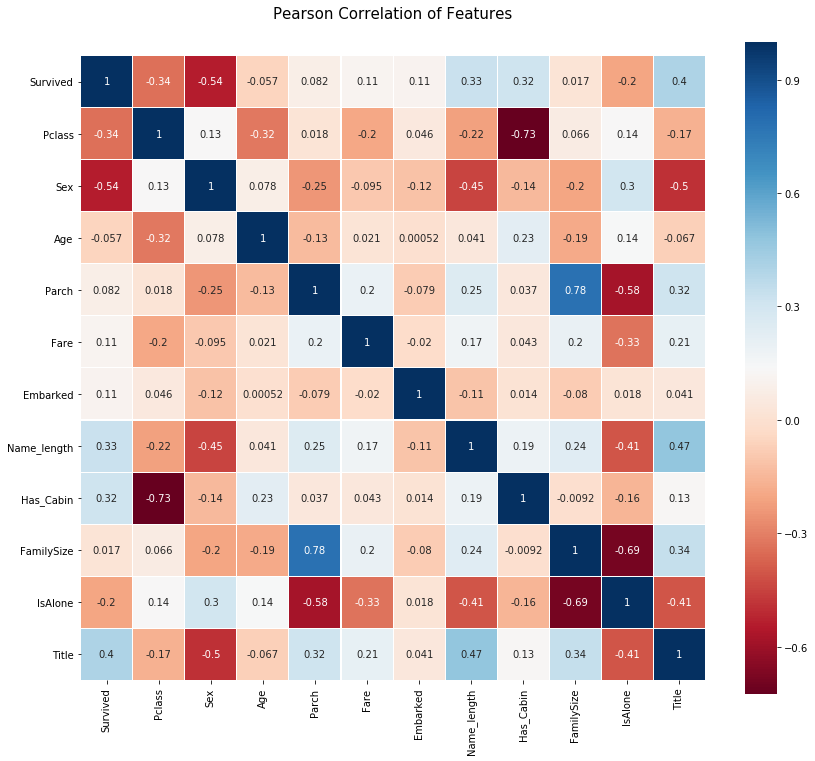

In [55]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# 가져가야할 유용한 데이터는 두가지가 있다, 패밀리 사이즈와 parch(Parents and Children ) 이다. 

# Pairplots

데이터 분배 관찰